#### Exploratory Data Analysis

In [ ]:
!pip install category_encoders==2.*

In [ ]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/buildweek-kickstarter/data-science/main/data/kickstarter_complete.csv?token=AOY4UTCBI22YIVLKAL35GEK7NJOR4')

print(df.shape)
df

(999, 13)


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 11:36:00,1000,2015-08-11 12:12:28,0,failed,0,GB,0
1,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26 0:20:50,45000,2013-01-12 0:20:50,220,failed,3,US,220
2,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16 4:24:11,5000,2012-03-17 3:24:11,1,failed,1,US,1
3,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29 1:00:00,19500,2015-07-04 8:35:03,1283,canceled,14,US,1283
4,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01 13:38:27,50000,2016-02-26 13:38:27,52375,successful,224,US,52375
...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,1005848496,The 1st Motion Tracking DIY Smart Home Securit...,Gadgets,Technology,USD,2016-12-31 3:54:32,25000,2016-11-01 2:54:32,58978,live,397,US,7235
995,1005862247,Veterans,Photography,Photography,USD,2012-08-15 6:00:00,5000,2012-07-09 5:39:06,5637,successful,87,US,5637
996,1005863674,MY VERY FIRST KICKSTARTER,Movie Theaters,Film & Video,USD,2014-08-12 20:08:35,6500,2014-07-13 20:08:35,27,failed,2,US,27
997,1005870420,This Song Is About You,Music,Music,USD,2014-07-11 23:35:00,40000,2014-06-11 23:35:00,0,failed,0,US,0


In [ ]:
print(df.columns)

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd pledged'],
      dtype='object')


In [ ]:
# Feature selection
df1 = df.filter(['name', 'category', 'main_category', 'currency', 'deadline', 'launched', 'goal', 'pledged', 'backers', 'state'], axis=1)

df1

,name,category,main_category,currency,deadline,launched,goal,pledged,backers,state
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 11:36:00,2015-08-11 12:12:28,1000,0,0,failed
1,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26 0:20:50,2013-01-12 0:20:50,45000,220,3,failed
2,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16 4:24:11,2012-03-17 3:24:11,5000,1,1,failed
3,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29 1:00:00,2015-07-04 8:35:03,19500,1283,14,canceled
4,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01 13:38:27,2016-02-26 13:38:27,50000,52375,224,successful
...,...,...,...,...,...,...,...,...,...,...
994,The 1st Motion Tracking DIY Smart Home Securit...,Gadgets,Technology,USD,2016-12-31 3:54:32,2016-11-01 2:54:32,25000,58978,397,live
995,Veterans,Photography,Photography,USD,2012-08-15 6:00:00,2012-07-09 5:39:06,5000,5637,87,successful
996,MY VERY FIRST KICKSTARTER,Movie Theaters,Film & Video,USD,2014-08-12 20:08:35,2014-07-13 20:08:35,6500,27,2,failed
997,This Song Is About You,Music,Music,USD,2014-07-11 23:35:00,2014-06-11 23:35:00,40000,0,0,failed


In [ ]:
# Convert date/time to engineer new feature
df1['deadline'] = pd.to_datetime(df1['deadline'])
df1['launched'] = pd.to_datetime(df1['launched'])

df1['length_of_campaign'] = (df1['deadline'] - df1['launched']).dt.days  

In [ ]:
df1

,name,category,main_category,currency,deadline,launched,goal,pledged,backers,state,length_of_campaign,project_success,percent_funded
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 11:36:00,2015-08-11 12:12:28,1000,0,0,failed,58,0,10000
1,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26 00:20:50,2013-01-12 00:20:50,45000,220,3,failed,45,0,45000220
2,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16 04:24:11,2012-03-17 03:24:11,5000,1,1,failed,30,0,50001
3,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29 01:00:00,2015-07-04 08:35:03,19500,1283,14,canceled,55,0,195001283
4,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01 13:38:27,2016-02-26 13:38:27,50000,52375,224,successful,35,1,5000052375
...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,The 1st Motion Tracking DIY Smart Home Securit...,Gadgets,Technology,USD,2016-12-31 03:54:32,2016-11-01 02:54:32,25000,58978,397,live,60,1,2500058978
995,Veterans,Photography,Photography,USD,2012-08-15 06:00:00,2012-07-09 05:39:06,5000,5637,87,successful,37,1,50005637
996,MY VERY FIRST KICKSTARTER,Movie Theaters,Film & Video,USD,2014-08-12 20:08:35,2014-07-13 20:08:35,6500,27,2,failed,30,0,650027
997,This Song Is About You,Music,Music,USD,2014-07-11 23:35:00,2014-06-11 23:35:00,40000,0,0,failed,30,0,400000


#### Baseline

In [ ]:
# Group into 2 outcomes: success & failed

success = ['successful', 'live']
failed = ['failed',
          'canceled',
          'suspended',
          'undefined'
          ]

In [ ]:
import numpy as np
col = 'state'
conditions = [df[col].isin(success), df[col].isin(failed)]
choices = ['1', '0']
df1['project_success'] = np.select(conditions, choices, default=np.nan)

In [ ]:
df1['project_success'].value_counts()

0    604
1    395
Name: project_success, dtype: int64

In [ ]:
df2 = df1[['category', 'main_category', 'currency', 'goal', 'pledged', 'backers', 'length_of_campaign', 'project_success', 'sentiments']]

In [ ]:
!pip install vaderSentiment

     |████████████████████████████████| 133kB 2.8MB/s 


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

sentiments =[] 
analyzer = SentimentIntensityAnalyzer()
for sentence in df['name']:
    vs = analyzer.polarity_scores(sentence)
    sentiments.append(vs['compound'])

In [ ]:
df1['sentiments'] = sentiments

In [ ]:
df2

,category,main_category,currency,goal,pledged,backers,length_of_campaign,project_success,sentiments
0,Poetry,Publishing,GBP,1000,0,0,58,0,0.0000
1,Narrative Film,Film & Video,USD,45000,220,3,45,0,0.0000
2,Music,Music,USD,5000,1,1,30,0,0.4019
3,Film & Video,Film & Video,USD,19500,1283,14,55,0,0.0000
4,Restaurants,Food,USD,50000,52375,224,35,1,0.0000
...,...,...,...,...,...,...,...,...,...
994,Gadgets,Technology,USD,25000,58978,397,60,1,0.6249
995,Photography,Photography,USD,5000,5637,87,37,1,0.0000
996,Movie Theaters,Film & Video,USD,6500,27,2,30,0,0.0000
997,Music,Music,USD,40000,0,0,30,0,0.0000


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Split train into train & val
from sklearn.model_selection import train_test_split
train, val = train_test_split(df1, train_size=0.80, test_size=0.20, 
                              stratify=df2['project_success'], random_state=42)

In [ ]:
# Baseline
target = 'project_success'
y_train = train[target]
y_train.value_counts(normalize=True)

0    0.604506
1    0.395494
Name: project_success, dtype: float64

#### Logistic Regression

In [ ]:
# Arrange data into X features matrix and y target vector
features = ['category', 'main_category', 'currency', 'goal', 'pledged', 'backers', 'length_of_campaign', 'sentiments']
target = 'project_success'

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

In [ ]:
# Check shape before encoding
X_train.shape, X_val.shape

((799, 8), (200, 8))

In [ ]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

In [ ]:
# Check shape after encoding
X_train_encoded.shape, X_val_encoded.shape

((799, 882), (200, 882))

In [ ]:
X_train_encoded.head()

,category_Drinks,category_Painting,category_Product Design,category_Apparel,category_Restaurants,category_Apps,category_Hardware,category_Fiction,category_Shorts,category_Plays,category_Cookbooks,category_Classical Music,category_Animation,category_Fashion,category_Theater,category_Crafts,category_Documentary,category_Pop,category_Video Games,category_Comedy,category_Comics,category_Public Art,category_Music,category_Performance Art,category_Hip-Hop,category_Film & Video,category_Gadgets,category_Tabletop Games,category_Photography,category_Rock,category_Art Books,category_Digital Art,category_People,category_World Music,category_Small Batch,category_Calendars,category_Narrative Film,category_DIY,category_Electronic Music,category_Food,...,"pledged_41,136.55",pledged_4670,pledged_797,pledged_26695,"pledged_12,760.31",pledged_1159,pledged_585,pledged_2036,pledged_17563,pledged_1653,pledged_325,pledged_1000,"pledged_52,837.51","pledged_2,354.50","pledged_5,772.15","pledged_30,353.80",pledged_2752,pledged_587,pledged_5178,"pledged_7,508.46",pledged_1005,pledged_2315,pledged_660,pledged_151,"pledged_103,114.50",pledged_218,pledged_2020,pledged_9047,pledged_30066,pledged_3238,pledged_1765,pledged_61,pledged_1207,pledged_12857,pledged_843743,pledged_10414,pledged_500,backers,length_of_campaign,sentiments
772,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,81,30,0.0000
786,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,16,0.4019
339,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,35,0.0000
771,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,38,0.4019
39,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,855,30,0.0000


In [ ]:
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)

In [ ]:
X_val_imputed[:5]  # Slice to the first 5 observations

array([[ 0.    ,  0.    ,  0.    , ..., 24.    , 30.    ,  0.    ],
       [ 0.    ,  1.    ,  0.    , ..., 19.    , 49.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    , ..., 16.    , 30.    , -0.1779],
       [ 0.    ,  0.    ,  0.    , ...,  0.    , 24.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    , ..., 32.    , 33.    , -0.1531]])

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

In [ ]:
X_val_scaled[:5]

array([[-0.11814987, -0.11814987, -0.22956681, ..., -0.22137588,
        -0.27938589, -0.26426847],
       [-0.11814987,  8.46382677, -0.22956681, ..., -0.23594536,
         1.31811212, -0.26426847],
       [-0.11814987, -0.11814987, -0.22956681, ..., -0.24468705,
        -0.27938589, -0.96041806],
       [-0.11814987, -0.11814987, -0.22956681, ..., -0.29130939,
        -0.78385895, -0.26426847],
       [-0.11814987, -0.11814987, -0.22956681, ..., -0.19806471,
        -0.02714936, -0.86337191]])

In [ ]:
# Fit our model!
model = LogisticRegressionCV()
model.fit(X_train_scaled, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [ ]:
# Predicting score
model.score(X_val_scaled, y_val)

0.69

#### Random Forest

In [ ]:
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(random_state=0, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.835


#### Permutation Importances

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=20, 
                           random_state=42, 
                           n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train);

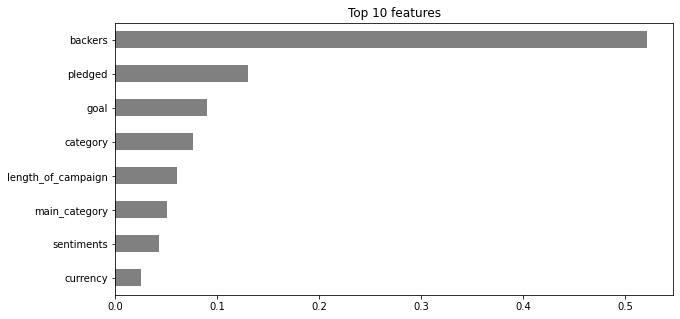

In [ ]:
# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

#### Tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
model = Sequential()
model.add(Dense(12, input_dim=882, kernel_initializer='normal', activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 12)                10596     
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 104       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 9         
Total params: 10,709
Trainable params: 10,709
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

In [ ]:
X_train_encoded.head()

,category_Drinks,category_Painting,category_Product Design,category_Apparel,category_Restaurants,category_Apps,category_Hardware,category_Fiction,category_Shorts,category_Plays,category_Cookbooks,category_Classical Music,category_Animation,category_Fashion,category_Theater,category_Crafts,category_Documentary,category_Pop,category_Video Games,category_Comedy,category_Comics,category_Public Art,category_Music,category_Performance Art,category_Hip-Hop,category_Film & Video,category_Gadgets,category_Tabletop Games,category_Photography,category_Rock,category_Art Books,category_Digital Art,category_People,category_World Music,category_Small Batch,category_Calendars,category_Narrative Film,category_DIY,category_Electronic Music,category_Food,...,"pledged_41,136.55",pledged_4670,pledged_797,pledged_26695,"pledged_12,760.31",pledged_1159,pledged_585,pledged_2036,pledged_17563,pledged_1653,pledged_325,pledged_1000,"pledged_52,837.51","pledged_2,354.50","pledged_5,772.15","pledged_30,353.80",pledged_2752,pledged_587,pledged_5178,"pledged_7,508.46",pledged_1005,pledged_2315,pledged_660,pledged_151,"pledged_103,114.50",pledged_218,pledged_2020,pledged_9047,pledged_30066,pledged_3238,pledged_1765,pledged_61,pledged_1207,pledged_12857,pledged_843743,pledged_10414,pledged_500,backers,length_of_campaign,sentiments
772,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,81,30,0.0000
786,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,16,0.4019
339,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,35,0.0000
771,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,38,0.4019
39,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,855,30,0.0000


In [ ]:
history = model.fit(X_train_encoded, y_train, epochs=150, batch_size=50,  verbose=1, validation_split=0.2)